# Faster RCNN
Here's a simple training and testing procedure to analyze the results of a state of art object detection technique on a plastic bottle dataset.

The code is paired with a similar procedure but on YOLOv5

In [ ]:
import os
import io
import cv2
import time
import copy
import torch
import contextlib
import torchvision
import torch.utils.data

import numpy as np
import torchvision.transforms as T

!pip install pycocotools

from PIL import Image
# from tqdm import tqdm
from tqdm.notebook import tqdm
from pycocotools.coco import COCO
from matplotlib import pyplot as plt
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as coco_mask
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Seed.
np.random.seed(66)
torch.manual_seed(66)

# Hyperparameters.
EPOCH = 10
BATCH_SIZE = 3
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Dataset fetch
Firstly, we download the *trash-plastic-bottle-detection* dataset from the cloud. The source is taken from the public online repository of *roboflow* and uploaded to a private Google Drive.

The dataset contains:

*  **Train Set**: 299 imgs
*  **Test Set**: 13 imgs





In [ ]:
from google.colab import drive
# Here you must have the dataset uploaded on your cloud
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Here you can decide to load the weights for a pre-trained version of Faster RCNN.

We expect to have a **more precise** model when weights are loaded.



In [ ]:
# Load a model pre-trained on COCO.
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=False)

# Replace the classifier with a new one, that has num_classes which is user-defined.
# 1 class (bottle) + background.
num_classes = 2

# Get number of input features for the classifier.
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one.
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]


# Dataset setup
Each image is paired with its bounding box(es).


YOLO format for bounding box annotations:
1.   xmin
2.   ymin
3.   xmax
4.   ymax



In [ ]:
class PlasticBottlesDataset(Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # Load all image files, sorting them to ensure that they are aligned.
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.bboxes = list(sorted(os.listdir(os.path.join(root, "labels"))))

    def __getitem__(self, idx):
        # Load images and masks.
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "labels", self.bboxes[idx])
        img = Image.open(img_path).convert("RGB")
        #print()
        #print(mask_path)
        # Get bounding box coordinates for each mask.
        boxes = []

        with open(mask_path) as f:
            for box in f.readlines():
                x_center, y_center, width, height = box.split(" ")[1:5]
                x_center = float(x_center)
                y_center = float(y_center)
                width = float(width)
                height = float(height)


                xmin = round(max((x_center - width / 2) * img.size[0],0))
                xmax = round(min((x_center + width / 2) * img.size[0],img.size[0]))
                ymin = round(max((y_center - height / 2) * img.size[1],0))
                ymax = round(min((y_center + height / 2) * img.size[1],img.size[1]))

                #x, y, w, h = map(float, box.strip().split()[1:])
                #xmin, ymin = int((x - w / 2) * img.size[0]), int((y - h / 2) * img.size[1])
                #xmax, ymax = int((x + w / 2) * img.size[0]), int((y + h / 2) * img.size[1])
                #print([xmin, ymin, xmax, ymax])
                #print(mask_path)
                boxes.append([int(xmin), int(ymin), int(xmax), int(ymax)])


        # Convert everything into a torch.Tensor.
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # There is only one class.
        labels = torch.ones((len(boxes),), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # Suppose all instances are not crowd.
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)
        else:
            img = np.asarray(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

A brief bunch of code useful to check if each ground truth bounding box is actually correct

/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


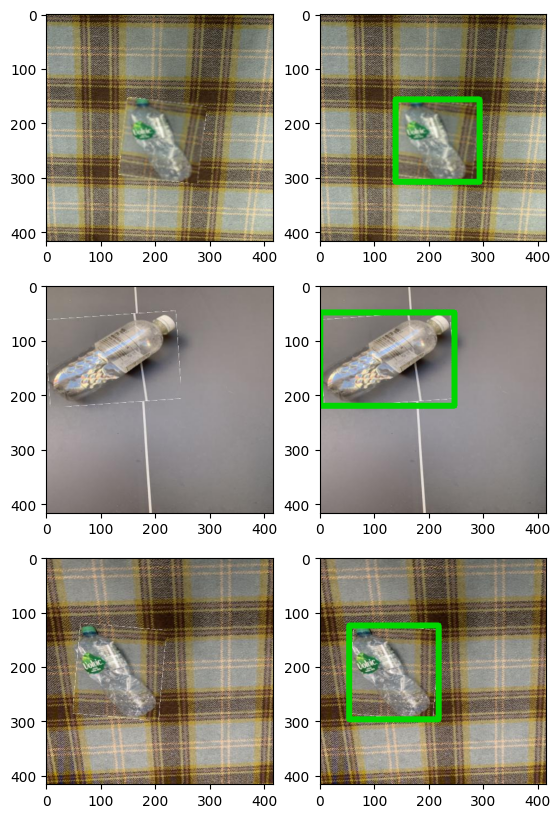

In [ ]:
def show_dataset(sample_data_loader):
    plt.figure(figsize=(10,10))
    plot_samples = 3
    plot_cols = 3
    _plot_idx = 0
    for i, (image, metadata) in enumerate(sample_data_loader):
        if i >= plot_samples:
            break

        _plot_idx += 1
        plt.subplot(plot_samples, plot_cols, _plot_idx)

        image = image.squeeze().numpy()
        plt.imshow(image)

        _plot_idx += 1
        plt.subplot(plot_samples, plot_cols, _plot_idx)
        boxes = metadata["boxes"]  # 1, N, 4.
        if len(boxes.shape) == 3:
            boxes = boxes.squeeze(0)
        image_with_bbox = image.copy()
        for bbox in boxes:
            xmin, ymin, xmax, ymax = bbox
            xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
            pt1 = (xmin, ymin)
            pt2 = (xmax, ymax)
            cv2.rectangle(image_with_bbox, pt1, pt2, (0, 215, 0), 10)

        plt.imshow(image_with_bbox)
        _plot_idx += 1

# Perform data visualization.
dataset = PlasticBottlesDataset("/content/drive/MyDrive/trash-plastic-bottle-detection-3/train", None)

# You may want to use a DataLoader, but it's not mandatory.
sample_data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

# For each sample show:
# 1) The RGB image
# 2) The Bounding Boxes over the RGB frame
#    - HINT: use cv2.rectangle() to draw a rect, or matplotlib.patches.Rectangle()
show_dataset(sample_data_loader)

Each image must be a tensor to be passed to our model

In [ ]:
# Transformations.
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

# Utils for train/test DataLoaders.
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
# Dataset.
dataset_train = PlasticBottlesDataset("/content/drive/MyDrive/trash-plastic-bottle-detection-3/train", get_transform(train=True))
dataset_test = PlasticBottlesDataset("/content/drive/MyDrive/trash-plastic-bottle-detection-3/test", get_transform(train=False))

# DataLoaders.
data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE,
                                          shuffle=True, collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE,
                                               shuffle=False, collate_fn=collate_fn)

# Move model to the right device.
model.to(DEVICE)

# Define the optimizer and a learning rate scheduler.
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.0005,
    momentum=0.9,
    weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3,
                                               gamma=0.1)

In [ ]:
import gc
gc.collect()

17832

# Training
Perform the training phase and print times.

In [ ]:
# Training step.
print(f"Start training on {DEVICE} [...]")
start = time.time()
losses_epochs = []

def train_epoch(model, optimizer, data_loader_train, device, epoch):
    model.train()
    losses_epoch = []
    for i, (images, targets) in (tepoch := tqdm(enumerate(data_loader_train), unit="batch", total=len(data_loader_train))):
        tepoch.set_description(f"Epoch {epoch}")

        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        model_time = time.time()
        loss_dict = model(images, targets)
        model_time = time.time() - model_time

        losses = sum(loss for loss in loss_dict.values())
        losses_epoch.append(losses.cpu().detach().numpy())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        tepoch.set_postfix(loss=losses.item())
    print("Mean Loss per epoch: ", np.mean(losses_epoch))
    losses_epochs.append(np.mean(losses_epoch))

for epoch in range(EPOCH):
    train_epoch(model, optimizer, data_loader_train, DEVICE, epoch)
    lr_scheduler.step()

end = time.time()
print("Total training time: ", end - start)

Start training on cuda [...]


  0%|          | 0/97 [00:00<?, ?batch/s]

Mean Loss per epoch:  0.49508768


  0%|          | 0/97 [00:00<?, ?batch/s]

Mean Loss per epoch:  0.18499827


  0%|          | 0/97 [00:00<?, ?batch/s]

Mean Loss per epoch:  0.16069965


  0%|          | 0/97 [00:00<?, ?batch/s]

Mean Loss per epoch:  0.14748742


  0%|          | 0/97 [00:00<?, ?batch/s]

Mean Loss per epoch:  0.14399263


  0%|          | 0/97 [00:00<?, ?batch/s]

Mean Loss per epoch:  0.13985398


  0%|          | 0/97 [00:00<?, ?batch/s]

Mean Loss per epoch:  0.13704139


  0%|          | 0/97 [00:00<?, ?batch/s]

Mean Loss per epoch:  0.13642766


  0%|          | 0/97 [00:00<?, ?batch/s]

Mean Loss per epoch:  0.13643722


  0%|          | 0/97 [00:00<?, ?batch/s]

Mean Loss per epoch:  0.13625476
Total training time:  700.8541703224182


# Plot the loss variation

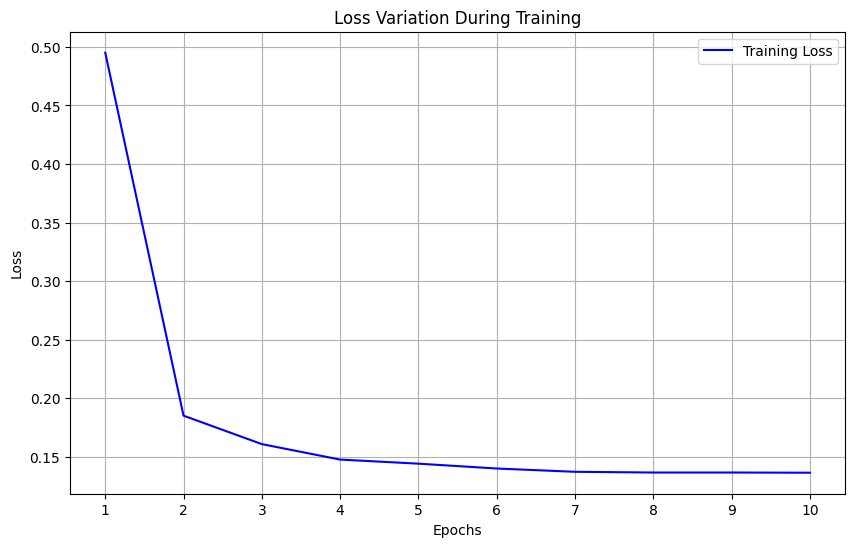

In [ ]:
# Example loss values
# Number of epochs
epochs = range(1, len(losses_epochs) + 1)

# Plotting the loss variation
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses_epochs, 'b', label='Training Loss')
plt.title('Loss Variation During Training')
plt.xticks(epochs, epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("Training time:", (end - start)/60)

Training time: 11.68090283870697


# Define CocoEvaluator for the metrics evaluation

In [ ]:
class CocoEvaluator:
    def __init__(self, coco_gt, iou_types):
        assert isinstance(iou_types, (list, tuple))
        coco_gt = copy.deepcopy(coco_gt)
        self.coco_gt = coco_gt

        self.iou_types = iou_types
        self.coco_eval = {}
        for iou_type in iou_types:
            self.coco_eval[iou_type] = COCOeval(coco_gt, iouType=iou_type)

        self.img_ids = []
        self.eval_imgs = {k: [] for k in iou_types}

    def update(self, predictions):
        img_ids = list(np.unique(list(predictions.keys())))
        self.img_ids.extend(img_ids)

        for iou_type in self.iou_types:
            results = self.prepare(predictions, iou_type)
            with contextlib.redirect_stdout(io.StringIO()):
                coco_dt = COCO.loadRes(self.coco_gt, results) if results else COCO()
            coco_eval = self.coco_eval[iou_type]

            coco_eval.cocoDt = coco_dt
            coco_eval.params.imgIds = list(img_ids)
            img_ids, eval_imgs = coco_evaluate(coco_eval)

            self.eval_imgs[iou_type].append(eval_imgs)

    def synchronize_between_processes(self):
        for iou_type in self.iou_types:
            self.eval_imgs[iou_type] = np.concatenate(self.eval_imgs[iou_type], 2)
            create_common_coco_eval(self.coco_eval[iou_type], self.img_ids, self.eval_imgs[iou_type])

    def accumulate(self):
        for coco_eval in self.coco_eval.values():
            coco_eval.accumulate()

    def summarize(self):
        for iou_type, coco_eval in self.coco_eval.items():
            print(f"IoU metric: {iou_type}")
            coco_eval.summarize()

    def prepare(self, predictions, iou_type):
        if iou_type == "bbox":
            return self.prepare_for_coco_detection(predictions)
        if iou_type == "segm":
            return self.prepare_for_coco_segmentation(predictions)
        if iou_type == "keypoints":
            return self.prepare_for_coco_keypoint(predictions)
        raise ValueError(f"Unknown iou type {iou_type}")

    def prepare_for_coco_detection(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "bbox": box,
                        "score": scores[k],
                    }
                    for k, box in enumerate(boxes)
                ]
            )
        return coco_results

    def prepare_for_coco_segmentation(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            scores = prediction["scores"]
            labels = prediction["labels"]
            masks = prediction["masks"]

            masks = masks > 0.5

            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            rles = [
                mask_util.encode(np.array(mask[0, :, :, np.newaxis], dtype=np.uint8, order="F"))[0] for mask in masks
            ]
            for rle in rles:
                rle["counts"] = rle["counts"].decode("utf-8")

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "segmentation": rle,
                        "score": scores[k],
                    }
                    for k, rle in enumerate(rles)
                ]
            )
        return coco_results

    def prepare_for_coco_keypoint(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()
            keypoints = prediction["keypoints"]
            keypoints = keypoints.flatten(start_dim=1).tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "keypoints": keypoint,
                        "score": scores[k],
                    }
                    for k, keypoint in enumerate(keypoints)
                ]
            )
        return coco_results


def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)


def merge(img_ids, eval_imgs):
    import torch.distributed as dist

    def is_dist_avail_and_initialized():
        if not dist.is_available():
            return False
        if not dist.is_initialized():
            return False
        return True

    def get_world_size():
        if not is_dist_avail_and_initialized():
            return 1
        return dist.get_world_size()

    def all_gather(data):
        world_size = get_world_size()
        if world_size == 1:
            return [data]
        data_list = [None] * world_size
        dist.all_gather_object(data_list, data)
        return data_list

    all_img_ids = all_gather(img_ids)
    all_eval_imgs = all_gather(eval_imgs)

    merged_img_ids = []
    for p in all_img_ids:
        merged_img_ids.extend(p)

    merged_eval_imgs = []
    for p in all_eval_imgs:
        merged_eval_imgs.append(p)

    merged_img_ids = np.array(merged_img_ids)
    merged_eval_imgs = np.concatenate(merged_eval_imgs, 2)

    # Keep only unique (and in sorted order) images.
    merged_img_ids, idx = np.unique(merged_img_ids, return_index=True)
    merged_eval_imgs = merged_eval_imgs[..., idx]

    return merged_img_ids, merged_eval_imgs


def create_common_coco_eval(coco_eval, img_ids, eval_imgs):
    img_ids, eval_imgs = merge(img_ids, eval_imgs)
    img_ids = list(img_ids)
    eval_imgs = list(eval_imgs.flatten())

    coco_eval.evalImgs = eval_imgs
    coco_eval.params.imgIds = img_ids
    coco_eval._paramsEval = copy.deepcopy(coco_eval.params)


def coco_evaluate(imgs):
    with contextlib.redirect_stdout(io.StringIO()):
        imgs.evaluate()
    return imgs.params.imgIds, np.asarray(imgs.evalImgs).reshape(-1, len(imgs.params.areaRng), len(imgs.params.imgIds))

In [ ]:
class FilterAndRemapCocoCategories:
    def __init__(self, categories, remap=True):
        self.categories = categories
        self.remap = remap

    def __call__(self, image, target):
        anno = target["annotations"]
        anno = [obj for obj in anno if obj["category_id"] in self.categories]
        if not self.remap:
            target["annotations"] = anno
            return image, target
        anno = copy.deepcopy(anno)
        for obj in anno:
            obj["category_id"] = self.categories.index(obj["category_id"])
        target["annotations"] = anno
        return image, target


def convert_coco_poly_to_mask(segmentations, height, width):
    masks = []
    for polygons in segmentations:
        rles = coco_mask.frPyObjects(polygons, height, width)
        mask = coco_mask.decode(rles)
        if len(mask.shape) < 3:
            mask = mask[..., None]
        mask = torch.as_tensor(mask, dtype=torch.uint8)
        mask = mask.any(dim=2)
        masks.append(mask)
    if masks:
        masks = torch.stack(masks, dim=0)
    else:
        masks = torch.zeros((0, height, width), dtype=torch.uint8)
    return masks


class ConvertCocoPolysToMask:
    def __call__(self, image, target):
        w, h = image.size

        image_id = target["image_id"]
        image_id = torch.tensor([image_id])

        anno = target["annotations"]

        anno = [obj for obj in anno if obj["iscrowd"] == 0]

        boxes = [obj["bbox"] for obj in anno]
        # guard against no boxes via resizing
        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
        boxes[:, 2:] += boxes[:, :2]
        boxes[:, 0::2].clamp_(min=0, max=w)
        boxes[:, 1::2].clamp_(min=0, max=h)

        classes = [obj["category_id"] for obj in anno]
        classes = torch.tensor(classes, dtype=torch.int64)

        segmentations = [obj["segmentation"] for obj in anno]
        masks = convert_coco_poly_to_mask(segmentations, h, w)

        keypoints = None
        if anno and "keypoints" in anno[0]:
            keypoints = [obj["keypoints"] for obj in anno]
            keypoints = torch.as_tensor(keypoints, dtype=torch.float32)
            num_keypoints = keypoints.shape[0]
            if num_keypoints:
                keypoints = keypoints.view(num_keypoints, -1, 3)

        keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
        boxes = boxes[keep]
        classes = classes[keep]
        masks = masks[keep]
        if keypoints is not None:
            keypoints = keypoints[keep]

        target = {}
        target["boxes"] = boxes
        target["labels"] = classes
        target["masks"] = masks
        target["image_id"] = image_id
        if keypoints is not None:
            target["keypoints"] = keypoints

        # for conversion to coco api
        area = torch.tensor([obj["area"] for obj in anno])
        iscrowd = torch.tensor([obj["iscrowd"] for obj in anno])
        target["area"] = area
        target["iscrowd"] = iscrowd

        return image, target


def _coco_remove_images_without_annotations(dataset, cat_list=None):
    def _has_only_empty_bbox(anno):
        return all(any(o <= 1 for o in obj["bbox"][2:]) for obj in anno)

    def _count_visible_keypoints(anno):
        return sum(sum(1 for v in ann["keypoints"][2::3] if v > 0) for ann in anno)

    min_keypoints_per_image = 10

    def _has_valid_annotation(anno):
        # If it's empty, there is no annotation.
        if len(anno) == 0:
            return False
        # If all boxes have close to zero area, there is no annotation.
        if _has_only_empty_bbox(anno):
            return False
        # Keypoints task have a slight different critera for considering
        # if an annotation is valid.
        if "keypoints" not in anno[0]:
            return True
        # For keypoint detection tasks, only consider valid images those
        # containing at least min_keypoints_per_image.
        if _count_visible_keypoints(anno) >= min_keypoints_per_image:
            return True
        return False

    assert isinstance(dataset, torchvision.datasets.CocoDetection)
    ids = []
    for ds_idx, img_id in enumerate(dataset.ids):
        ann_ids = dataset.coco.getAnnIds(imgIds=img_id, iscrowd=None)
        anno = dataset.coco.loadAnns(ann_ids)
        if cat_list:
            anno = [obj for obj in anno if obj["category_id"] in cat_list]
        if _has_valid_annotation(anno):
            ids.append(ds_idx)

    dataset = torch.utils.data.Subset(dataset, ids)
    return dataset


def convert_to_coco_api(ds):
    coco_ds = COCO()
    # Annotation IDs need to start at 1, not 0, see torchvision issue #1530.
    ann_id = 1
    dataset = {"images": [], "categories": [], "annotations": []}
    categories = set()
    for img_idx in range(len(ds)):
        # Find better way to get target.
        # targets = ds.get_annotations(img_idx)
        img, targets = ds[img_idx]
        image_id = targets["image_id"].item()
        img_dict = {}
        img_dict["id"] = image_id
        img_dict["height"] = img.shape[-2]
        img_dict["width"] = img.shape[-1]
        dataset["images"].append(img_dict)
        bboxes = targets["boxes"]
        bboxes[:, 2:] -= bboxes[:, :2]
        bboxes = bboxes.tolist()
        labels = targets["labels"].tolist()
        areas = targets["area"].tolist()
        iscrowd = targets["iscrowd"].tolist()
        if "masks" in targets:
            masks = targets["masks"]
            # Make masks Fortran contiguous for coco_mask.
            masks = masks.permute(0, 2, 1).contiguous().permute(0, 2, 1)
        if "keypoints" in targets:
            keypoints = targets["keypoints"]
            keypoints = keypoints.reshape(keypoints.shape[0], -1).tolist()
        num_objs = len(bboxes)
        for i in range(num_objs):
            ann = {}
            ann["image_id"] = image_id
            ann["bbox"] = bboxes[i]
            ann["category_id"] = labels[i]
            categories.add(labels[i])
            ann["area"] = areas[i]
            ann["iscrowd"] = iscrowd[i]
            ann["id"] = ann_id
            if "masks" in targets:
                ann["segmentation"] = coco_mask.encode(masks[i].numpy())
            if "keypoints" in targets:
                ann["keypoints"] = keypoints[i]
                ann["num_keypoints"] = sum(k != 0 for k in keypoints[i][2::3])
            dataset["annotations"].append(ann)
            ann_id += 1
    dataset["categories"] = [{"id": i} for i in sorted(categories)]
    coco_ds.dataset = dataset
    coco_ds.createIndex()
    return coco_ds


def get_coco_api_from_dataset(dataset):
    for _ in range(10):
        if isinstance(dataset, torchvision.datasets.CocoDetection):
            break
        if isinstance(dataset, torch.utils.data.Subset):
            dataset = dataset.dataset
    if isinstance(dataset, torchvision.datasets.CocoDetection):
        return dataset.coco
    return convert_to_coco_api(dataset)


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, transforms):
        super().__init__(img_folder, ann_file)
        self._transforms = transforms

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        image_id = self.ids[idx]
        target = dict(image_id=image_id, annotations=target)
        if self._transforms is not None:
            img, target = self._transforms(img, target)
        return img, target


def get_coco(root, image_set, transforms, mode="instances"):
    anno_file_template = "{}_{}2017.json"
    PATHS = {
        "train": ("train2017", os.path.join("annotations", anno_file_template.format(mode, "train"))),
        "val": ("val2017", os.path.join("annotations", anno_file_template.format(mode, "val"))),
        # "train": ("val2017", os.path.join("annotations", anno_file_template.format(mode, "val")))
    }

    t = [ConvertCocoPolysToMask()]

    if transforms is not None:
        t.append(transforms)
    transforms = T.Compose(t)

    img_folder, ann_file = PATHS[image_set]
    img_folder = os.path.join(root, img_folder)
    ann_file = os.path.join(root, ann_file)

    dataset = CocoDetection(img_folder, ann_file, transforms=transforms)

    if image_set == "train":
        dataset = _coco_remove_images_without_annotations(dataset)

    # dataset = torch.utils.data.Subset(dataset, [i for i in range(500)])

    return dataset


def get_coco_kp(root, image_set, transforms):
    return get_coco(root, image_set, transforms, mode="person_keypoints")

# Testing

In [ ]:
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")

    coco = get_coco_api_from_dataset(data_loader.dataset)
    coco_evaluator = CocoEvaluator(coco, ["bbox"])
    model.eval()
    times = []
    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        start = time.time()
        with torch.no_grad():
            outputs = model(images)
        end = time.time()
        times.append(end-start)
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time

    coco_evaluator.synchronize_between_processes()

    # Accumulate predictions from all images.
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    print(np.mean(times))
    return coco_evaluator

# Evaluation step.
evaluate(model, data_loader_test, DEVICE)

creating index...
index created!
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.547
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.953
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.657
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.402
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.576
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.546
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.577
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.585
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.400
 Average Recall  

# Example
Plot an output of the Faster RCNN with the ground truth bbox



*   Green: ground truth bounding box
*   Red: predicted bounding box



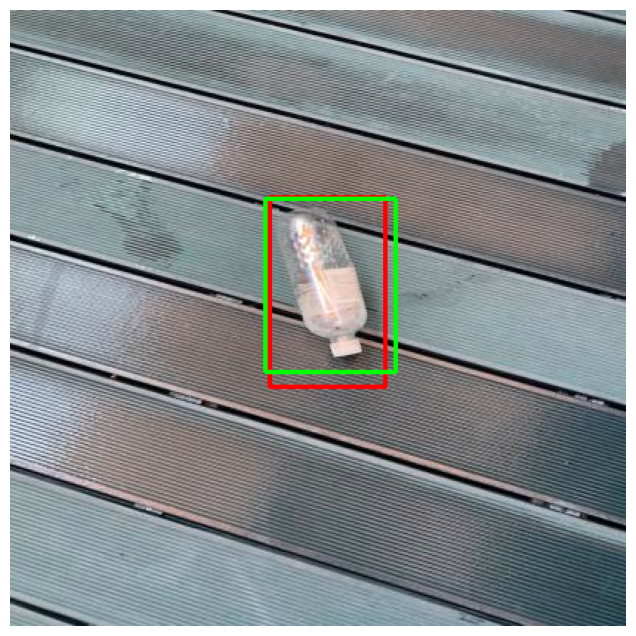

In [ ]:


dataset_test = PlasticBottlesDataset("/content/drive/MyDrive/trash-plastic-bottle-detection-3/test", get_transform(train=False))
data_loader = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE,
                                               shuffle=True, collate_fn=collate_fn)
# Example:
cpu_device = torch.device("cpu")

images, targets = next(iter(data_loader))
gx1, gy1, gx2, gy2 = targets[0]['boxes'][0]

images = list(img.to(DEVICE) for img in images)
image_rgb = images[0].permute(1, 2, 0).cpu().numpy()
image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)

if torch.cuda.is_available():
  torch.cuda.synchronize()
with torch.no_grad():
  detections = model(images)

# Loop through the detections and draw bounding boxes on the image
bestScore = 0
for i,_ in enumerate(range(len(detections[0]['boxes']))):

  score = detections[0]['scores'][i]
  if score > bestScore:
    bestScore = score
    x1, y1, x2, y2 = detections[0]['boxes'][i]

# Draw the bounding box on the image
cv2.rectangle(image_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
cv2.rectangle(image_rgb, (int(gx1), int(gy1)), (int(gx2), int(gy2)), (0, 255, 0), 2)

# Display the image with bounding boxes
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()
